In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################


# TSA Adsorption Cycle for Carbon Capture

## Learning outcomes


- Demonstrate the use of the IDAES fixed bed temperature swing adsorption (TSA) 0D unit model
- Initialize the IDAES fixed bed TSA 0D unit model
- Simulate the IDAES fixed bed TSA 0D unit model by solving a square problem
- Generate and analyze results


## Problem Statement

This Jupyter notebook shows the simulation of a fixed bed TSA cycle for carbon capture by using the fixed bed TSA 0D unit model in IDAES. The fixed bed TSA model consists of a 0D equilibrium-based shortcut model composed of four steps a) heating, b) cooling, c) pressurization, and d) adsorption. Note that the equations in the IDAES fixed bed TSA 0D unit model and the input specifications used in this tutorial for the feed stream have been taken from <a href="https://pubs.acs.org/doi/abs/10.1021/ie5048829">Joss et al. 2015</a>.


#### A diagram of the TSA adsorption cycle is given below: 

![](tsa_cycle.svg)


# Step 1: Import Libraries

### Import Pyomo pakages 

We will need the following components from the pyomo libraries.

- ConcreteModel (to create the Pyomo model that will contain the IDAES flowsheet)
- TransformationFactory (to apply certain transformations)
- SolverFactory (to set up the solver that will solve the problem)
- Constraint (to write constraints)
- Var (to declare variables)
- Objective (to declare an objective function)
- minimize (to minimize an objective function)
- value (to return the numerical value of an Pyomo objects such as variables, constraints or expressions)
- units (to handle units in Pyomo and IDAES)
- check_optimal_termination (this method returns the solution status from solver)

For further details on these components, please refer to the <a href="https://pyomo.readthedocs.io/en/latest/">Pyomo documentation</a>:

In [2]:
# python libraries
import os

# pyomo libraries
from pyomo.environ import (
    ConcreteModel,
    TransformationFactory,
    SolverFactory,
    Constraint,
    Var,
    Objective,
    minimize,
    value,
    units,
    check_optimal_termination,
)

### Import IDAES core components

To build, initialize, and solve IDAES flowsheets we will need the following core components/utilities:

- FlowsheetBlock (the flowsheet block contains idaes properties, time, and unit models)
- degrees_of_freedom (useful for debugging, this method returns the DOF of the model)
- FixedBedTSA0D (fixed bed TSA model unit model)
- util (some utility functions in IDAES)
- idaeslog (it's used to set output messages like warnings or errors)

For further details on these components, please refer to the <a href="https://idaes-pse.readthedocs.io/en/latest/">IDAES documentation</a>:

In [3]:
# import IDAES core libraries 
from idaes.core import FlowsheetBlock
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.core.util as iutil
import idaes.logger as idaeslog

# import tsa unit model
from idaes.models_extra.temperature_swing_adsorption import (
    FixedBedTSA0D,
    FixedBedTSA0DInitializer,
    Adsorbent,
)
from idaes.models_extra.temperature_swing_adsorption.util import tsa_summary, plot_tsa_profiles

## Step 2:  Constructing the Flowsheet

First, let's create a ConcreteModel and attach the flowsheet block to it.

In [4]:
# create concret model
m = ConcreteModel()

# create flowsheet
m.fs = FlowsheetBlock(dynamic=False)

### 2.1: Adding the TSA Unit Model

Now, we will be adding the fixed bed temperature swing adsorption (TSA) cycle model (assigned a name tsa).

The TSA unit model builds variables, constraints and expressions for a solid sorbent based TSA capture system. This IDAES model can take up to 11 config arguments:

1. `dynamic`: to set up the model as steady state. The IDAES fixed bed TSA 0D
   unit model only supports steady state as the dynamic nature of the adsorption
   cycle is handled in internal blocks for each cycle step of the unit. This
   config argument is used to enable the TSA unit model to connect with other
   IDAES unit models.
2. `adsorbent`: to set up the adsorbent to be used in the fixed bed TSA system. 
   Supported values currently are `Adsorbent.zeolite_13x`, `Adsorbent.mmen_mg_mof_74`, and `Adsorbent.polystyrene_amine`.
3. `number_of_beds`: to set up the number of beds to be used in the unit model.
   This config argument accepts either an `int` (model assumes a fixed number     of beds) or `None` (model calculates the number of beds).
4. `compressor`: indicates whether a compressor unit should be added to the
   fixed bed TSA system to calculate the energy required to overcome
   the pressure drop in the system. Supported values are `True` and `False`.
5. `compressor_properties`: indicates a property package to use in the compressor unit model.
6. `steam_calculation`: indicates whether a method to estimate the steam flow rate
   required in the desorption step should be included. Supported values are: `SteamCalculationType.none`,
   steam calculation method is not included. `SteamCalculationType.simplified`, a surrogate model is used
   to estimate the mass flow rate of steam. `SteamCalculationType.rigorous`, a heater unit model is
   included in the TSA system assuming total saturation.
7. `steam_properties`: indicates a property package to use for rigorous steam calculations. Currently, only the iapws95 property package is supported.
8. `transformation_method`: to set up the discretization method to be use for the time
   domain. The discretization method must be a method recognized by the
   Pyomo `TransformationFactory`. Supported values are `dae.finite_difference` and
   `dae.collocation`.
9. `transformation_scheme`: to set up the scheme to use when discretizing the time domain.
   Supported values are: `TransformationScheme.backward` and `TransformationScheme.forward` for finite difference transformation
   method. `TransformationScheme.lagrangeRadau` for collocation transformation method.
10. `finite_elements`: to set up the number of finite elements to use when discretizing
   the time domain.
11. `collocation_points`: to set up the number of collocation points to use per finite element
    when the discretization method is `dae.collocation`.
  
<div class="alert alert-block alert-info">
<b>Note:</b>  a default value defined in every IDAES unit class is used for
    a config argument when no value is passed in the time the unit model
    is called.
</div>

In [5]:
# add tsa unit
m.fs.tsa = FixedBedTSA0D(
    adsorbent=Adsorbent.zeolite_13x,
    number_of_beds=1)

### 2.2: Fix Specifications of Feed Stream in TSA Unit

The inlet speficications of the TSA unit are fixed to match the exhaust gas stream (stream 8) of case B31B in the NETL baseline report, which is a exhaust gas stream after 90% carbon capture by means of a solvent-based capture system. 

In [6]:
# fix inlet conditions of tsa unit - baseline case from Joss et al. 2015
flue_gas = {
    "flow_mol_comp": {
        "H2O": 0.0,
        "CO2": 0.00960*0.12,
        "N2": 0.00960*0.88,
        "O2": 0.0},
    "temperature": 300.0,
    "pressure": 1.0e5}
for i in m.fs.tsa.component_list:
    m.fs.tsa.inlet.flow_mol_comp[:, i].fix(flue_gas["flow_mol_comp"][i])
m.fs.tsa.inlet.temperature.fix(flue_gas["temperature"])
m.fs.tsa.inlet.pressure.fix(flue_gas["pressure"])

### 2.3: Fix DOF of TSA unit

The degrees of freedom of the TSA unit model are: adsorption and desorption temperatures, temperatures of heating and cooling fluids, column diameter, and column  height. These variables must be fixed to solve a square problem.

In [7]:
# fix design and operating variables of tsa unit - baseline case from Joss et al. 2015
m.fs.tsa.temperature_desorption.fix(430)
m.fs.tsa.temperature_adsorption.fix(310)
m.fs.tsa.temperature_heating.fix(440)
m.fs.tsa.temperature_cooling.fix(300)
m.fs.tsa.bed_diameter.fix(3/100)
m.fs.tsa.bed_height.fix(1.2)


# check the degrees of freedom
DOF = degrees_of_freedom(m)
print(f"The DOF of the TSA unit is {DOF}")

The DOF of the TSA unit is 0


### 2.4: Scaling Unit Models

Creating well scaled models is important for increasing the efficiency and reliability of solvers. Depending on unit models, variables and constraints are often badly scaled. IDAES unit models contain a method to scale variables and constraints to improve solver convergence. To apply the scaled factors defined in each unit model, we need to call the IDAES method `calculate_scaling_factors` in `idaes.core.util.scaling`.

In [8]:
# scaling factors
iutil.scaling.calculate_scaling_factors(m.fs.tsa)

### 2.5: Define  Solver and Solver Options

We select the solver that we will be using to initialize and solve the flowsheet.

In [9]:
# define solver and solver options
solver = "ipopt"
solver_options = {
    "mu_init": 1e-8,
    "bound_push": 1e-6,
    "nlp_scaling_method": "user-scaling",
    "tol": 1e-6,
    'halt_on_ampl_error': 'yes',
    }

### 2.6: Initialization of Unit Models

IDAES includes pre-written initialization routines for all unit models. To initialize the TSA unit model, call the method `m.fs.tsa.initialize()`.

<div class="alert alert-block alert-info">
<b>Note:</b> initialize methods in IDAES unit models solve a square problem,
    so the user needs to be sure that the degrees of freedom of the unit being
    initialized are zero.
</div>

In [10]:
# initialize tsa unit
initializer = FixedBedTSA0DInitializer(
    output_level=idaeslog.INFO,
    solver_options=solver_options)
initializer.initialize(m.fs.tsa)

2023-10-19 21:52:29 [INFO] idaes.init.fs.tsa: Starting fixed bed TSA initialization
2023-10-19 21:52:32 [INFO] idaes.init.fs.tsa.heating: Starting initialization of heating step.
2023-10-19 21:52:32 [INFO] idaes.init.fs.tsa.heating: Initialization of heating step completed optimal - Optimal Solution Found.
2023-10-19 21:52:34 [INFO] idaes.init.fs.tsa.cooling: Starting initialization of cooling step.
2023-10-19 21:52:35 [INFO] idaes.init.fs.tsa.cooling: Initialization of cooling step completed optimal - Optimal Solution Found.
2023-10-19 21:52:35 [INFO] idaes.init.fs.tsa.pressurization: Starting initialization of pressurization step.
2023-10-19 21:52:35 [INFO] idaes.init.fs.tsa.pressurization: Initialization of pressurization step completed optimal - Optimal Solution Found.
2023-10-19 21:52:35 [INFO] idaes.init.fs.tsa.adsorption: Starting initialization of adsorption step.
2023-10-19 21:52:35 [INFO] idaes.init.fs.tsa.adsorption: Initialization of adsorption step completed optimal - Opti

## Step 3:  Solve the TSA Unit Model

Now, we can simulate the TSA unit model by solving a square problem. For this, we need to set up the solver by using the pyomo component `SolverFactory`. We will be using the solver and solver options defined during the initialization.

In [11]:
# set up solver to solve flowsheet
solver = SolverFactory(solver)
solver.options = solver_options

# solve flowsheet
results = solver.solve(m, tee=True)

contains 4 component keys that are not exported as part of the NL file.
Skipping.
contains 2 component keys that are not exported as part of the NL file.
Skipping.
component keys that are not exported as part of the NL file.  Skipping.
Ipopt 3.13.2: mu_init=1e-08
bound_push=1e-06
nlp_scaling_method=user-scaling
tol=1e-06
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HS

In [12]:
# Check solver solve status
from pyomo.environ import TerminationCondition

assert results.solver.termination_condition == TerminationCondition.optimal

## Step 4:  Viewing the Simulation Results

We will call some utility methods defined in the TSA unit model to get displayed some key variables.

In [13]:
# summary tsa
tsa_summary(m.fs.tsa)



Summary - tsa
------------------------------------------------------------------------------------                                                                  Value  
    Adsorption temperature [K]                                     310.00
    Desorption temperature [K]                                     430.00
    Heating temperature [K]                                        440.00
    Cooling temperature [K]                                        300.00
    Column diameter [m]                                          0.030000
    Column length [m]                                              1.2000
    Column volume [m3]                                         0.00084823
    CO2 mole fraction at feed [%]                                  12.000
    Feed flow rate [mol/s]                                      0.0096000
    Feed velocity [m/s]                                           0.50008
    Minimum fluidization velocity [m/s]                            1.5207
    Time of h

In [14]:
import pytest

assert value(m.fs.tsa.purity) == pytest.approx(0.90219, abs=1e-5)
assert value(m.fs.tsa.recovery) == pytest.approx(0.89873, abs=1e-5)
assert value(m.fs.tsa.specific_energy) == pytest.approx(3.6532, abs=1e-4)

## Step 5:  Plotting Profiles

Call plots method in the FixedBedTSA0D model to generate profiles of temperature, pressure and $\mathrm{CO_{2}}$ concentration at the outlet of the column.

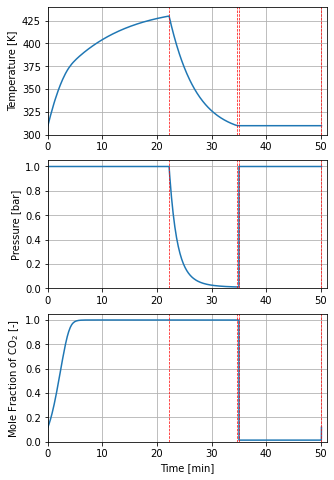

In [15]:
# profiles
plot_tsa_profiles(m.fs.tsa)
